In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import random
#import pymc as pm
import datetime

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# CONFIG

**Set sample to False if you want to run algos on entire dataset**

In [98]:
CONFIG = {
    'sample': True,
    'sample_months': 1, # how many months to sample (for development)
    'top_n_clusters': 1, # how many clusters to train
    'random_state': 123,
    'target_col': 'departures',
    'n_jobs': 4,  # gridsearch parallelization, might need to adjust based on your system
    'ts_splits': 5, # TimeSeriesSplit number of splits
    'ts_gap': 48,  # 2-day gap
    'visualize_clusters': False
}

FEATURE_COLS = {
    'categorical': ['isHoliday', 'has_kiosk', 'weather_cluster', 'workhours', 'commute', 'free', 'night'],
    'drop': ['sum', 'weather_code', 'timestamp', 'station_name', 'arrivals', 'num_docks_available', 'num_ebikes_available', 'capacity', 'cluster', 'sunset', 'sunrise', 'year', 'hour_extract', 'precipitation', 'wind_gusts_10m', 'dayofyear', 'dayofweek', 'delta'],
    'time': ['weekday', 'day', 'month', 'hour']
}

# DATA LOADING

In [2]:
df = pd.read_parquet("data/final/df.parquet")

In [100]:
FEATURE_COLS["drop"] = FEATURE_COLS["drop"] + [col for col in df.columns if (col.startswith("var") or col.startswith("avg"))]

In [101]:
print(df.shape)

(6464880, 94)


In [10]:
# Baseline-Performance for 0-heavy Data:
for i in range(0,10):
    df_cluster_subset = df[df["cluster"]==i]
    baseline = np.sqrt((sum(df_cluster_subset["departures"]**2))/len(df_cluster_subset))
    print(f"Baseline over all time cluster {i}: {baseline}")
print("---")
# TODO: Do we need to update this to conform with the "primary" train-test-split? (The one at the very top)
baseline = np.sqrt((sum(df["departures"]**2))/len(df))
print(f"Baseline over all time whole city: {baseline}")
print("---")
df_may_subset = df[(df["month"]==5) & (df["day"]>=10) & (df["day"]<=20)].copy()
for i in range(0,10):
    df_cluster_subset = df_may_subset[df_may_subset["cluster"]==i]
    baseline = np.sqrt((sum(df_cluster_subset["departures"]**2))/len(df_cluster_subset))
    print(f"Baseline over 10-20 may cluster {i}: {baseline}")
df_may_subset = df[(df["month"]==5) & (df["day"]>=21) & (df["day"]<=30)].copy()
for i in range(0,10):
    df_cluster_subset = df_may_subset[df_may_subset["cluster"]==i]
    baseline = np.sqrt((sum(df_cluster_subset["departures"]**2))/len(df_cluster_subset))
    print(f"Baseline over 21-30 may cluster {i}: {baseline}")

Baseline over all time cluster 0: 2.316139385547197
Baseline over all time cluster 1: 1.104808472655983
Baseline over all time cluster 2: 0.4637198876281428
Baseline over all time cluster 3: 0.7864280404968053
Baseline over all time cluster 4: 3.5115909397967626
Baseline over all time cluster 5: 2.5969880093352313
Baseline over all time cluster 6: 4.125818477787311
Baseline over all time cluster 7: 2.5778118929144425
Baseline over all time cluster 8: 0.5381255872385102
Baseline over all time cluster 9: 0.6125158954085695
---
Baseline over all time whole city: 1.6304479147363014
---
Baseline over 10-20 may cluster 0: 2.6057317658438466
Baseline over 10-20 may cluster 1: 1.2490472559591361
Baseline over 10-20 may cluster 2: 0.5400893375025043
Baseline over 10-20 may cluster 3: 0.9421146043436236
Baseline over 10-20 may cluster 4: 4.0827457833317435
Baseline over 10-20 may cluster 5: 2.955754414659583
Baseline over 10-20 may cluster 6: 4.672602181193581
Baseline over 10-20 may cluster 7: 

In [102]:
# REDUCE DATASET SIZE FOR DEVELOPMENT
if CONFIG['sample']:
    months = df['timestamp'].dt.month.unique()
    random_month = random.sample(list(months), CONFIG['sample_months'])
    df = df[df['timestamp'].dt.month.isin(random_month)]
    print(f'Sampled {CONFIG["sample_months"]} month(s): {random_month}')

Sampled 1 month(s): [np.int32(12)]


In [103]:
df.head()

,station_name,hour,departures,arrivals,hour_extract,temperature_2m,weather_code,rain,precipitation,snowfall,...,var_sum_station_nonnight,avg_sum_station_holiday,var_sum_station_holiday,avg_sum_station_commute,var_sum_station_commute,avg_sum_station_free,var_sum_station_free,avg_sum_station_unfriendly_weather,var_sum_station_unfriendly_weather,cluster
8016,10th & E St NW,0,0.0,0.0,0,5.136,0.0,0.0,0.0,0.0,...,15.351129,2.660256,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,5
8017,10th & E St NW,1,1.0,0.0,1,4.936,0.0,0.0,0.0,0.0,...,15.351129,2.660256,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,5
8018,10th & E St NW,2,0.0,0.0,2,4.536,1.0,0.0,0.0,0.0,...,15.351129,2.660256,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,5
8019,10th & E St NW,3,0.0,0.0,3,4.186,0.0,0.0,0.0,0.0,...,15.351129,2.660256,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,5
8020,10th & E St NW,4,0.0,0.0,4,3.786,3.0,0.0,0.0,0.0,...,15.351129,2.660256,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,5


In [104]:
# All remaining columns are considered numerical
FEATURE_COLS['numerical'] = [col for col in df.columns if col not in ([CONFIG['target_col']] + FEATURE_COLS['categorical'] + FEATURE_COLS['drop'] + FEATURE_COLS['time'])]

In [105]:
# Sanity check for features
print("Categorical:\n" + '\n'.join(f"  - {feature_col}" for feature_col in FEATURE_COLS['categorical']))
print("Drop:\n" + '\n'.join(f"  - {feature_col}" for feature_col in FEATURE_COLS['drop']))
print("Time:\n" + '\n'.join(f"  - {feature_col}" for feature_col in FEATURE_COLS['time']))
print("Numerical:\n" + '\n'.join(f"  - {feature_col}" for feature_col in FEATURE_COLS['numerical']))

Categorical:
  - isHoliday
  - has_kiosk
  - weather_cluster
  - workhours
  - commute
  - free
  - night
Drop:
  - sum
  - weather_code
  - timestamp
  - station_name
  - arrivals
  - departures
  - num_docks_available
  - num_ebikes_available
  - capacity
  - cluster
  - sunset
  - sunrise
  - year
  - day
  - hour_extract
  - precipitation
  - var_delta_station_total
  - avg_delta_station_total
  - avg_arrivals_station_total
  - avg_departures_station_total
  - var_arrivals_station_total
  - var_departures_station_total
  - avg_delta_station_night
  - var_delta_station_night
  - avg_arrivals_station_night
  - var_arrivals_station_night
  - avg_departures_station_night
  - var_departures_station_night
  - avg_delta_station_nonnight
  - var_delta_station_nonnight
  - avg_arrivals_station_nonnight
  - var_arrivals_station_nonnight
  - avg_departures_station_nonnight
  - var_departures_station_nonnight
  - avg_delta_station_holiday
  - var_delta_station_holiday
  - avg_arrivals_station_

In [ ]:
# Distribution of the target variable
plt.figure(figsize=(12, 5))
sns.histplot(df[CONFIG['target_col']])
plt.title(f'Distribution of {CONFIG["target_col"]}')
plt.show()

## Data preparation

In [ ]:
# Prepare data for modeling
def prepare_data(df, target_col, categorical_cols, numerical_cols, time_cols, drop_cols):
    # Drop rows with NaN values
    df_clean = df.dropna()
    print(f"Dropped {len(df) - len(df_clean)} rows with NaN values.")
    
    # Keep datetime for visualization purposes if available
    datetime_col = df_clean['timestamp'] if 'timestamp' in df_clean.columns else None
    
    # Drop columns defined in drop_cols
    df_clean = df_clean.drop(columns=drop_cols, errors='ignore')

    # Split features and target
    X = df_clean[categorical_cols + numerical_cols + time_cols]
    y = df_clean[target_col]
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=CONFIG['random_state'], shuffle=False)
    
    return X_train, y_train, X_test, y_test, datetime_col

# Test-apply data preparation
X, y, X_test, y_test, datetime_col = prepare_data(df, CONFIG['target_col'], FEATURE_COLS['categorical'], FEATURE_COLS['numerical'], FEATURE_COLS['time'], FEATURE_COLS['drop'])

print("Training set:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

In [ ]:
print("Test set:")
print(f"Features shape: {X_test.shape}")
print(f"Target shape: {y_test.shape}")

## Modeling
### Pipelines

In [108]:

from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

# Function to create model pipelines for each cluster
def create_model_pipelines(categorical_cols, numerical_cols, time_cols):
    
    preprocessor_plain = ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ], remainder='passthrough')
    
    preprocessor_onehot = ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('time', OneHotEncoder(handle_unknown='ignore', sparse_output=False), time_cols),
    ], remainder='passthrough')
    
    # Prepared but currently not in use
    preprocessor_sincos = ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('sin_month', sin_transformer(12), ['month']),
        ('sin_hour', sin_transformer(24), ['hour']),
        ('sin_weekday', sin_transformer(7), ['weekday']),
        ('cos_month', cos_transformer(12), ['month']),
        ('cos_hour', cos_transformer(24), ['hour']),
        ('cos_weekday', cos_transformer(7), ['weekday'])
    ], remainder='passthrough')
    
    # Create pipelines
    pipelines = {
        'linear': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', LinearRegression())
        ]),
        
        'lasso': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', Lasso(random_state=CONFIG['random_state']))
        ]),
        
        'ridge': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', Ridge(random_state=CONFIG['random_state']))
        ]),
        
        'decision_tree': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', DecisionTreeRegressor(random_state=CONFIG['random_state']))
        ]),
        'random_forest': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', RandomForestRegressor(random_state=CONFIG['random_state']))
        ]),
        'xgboost': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=CONFIG['random_state']))
        ]),
        'gbm': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', GradientBoostingRegressor(random_state=CONFIG['random_state']))
        ])
    }
    
    # Store preprocessor strategies
    preprocessing_strategies = {
        'plain': preprocessor_plain,
        'onehot': preprocessor_onehot,
        'sincos': preprocessor_sincos
    }
    
    preprocessor_plain.strategy_name = 'Plain'
    preprocessor_onehot.strategy_name = 'OneHot'  
    preprocessor_sincos.strategy_name = 'SinCos'
    
    return pipelines, preprocessing_strategies

# Function to get parameter grids
def get_param_grids(preprocessing_strategies):
    return {
        'linear': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ]
            },
        
        'lasso': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'regressor__alpha': np.logspace(-4,4,20),
            'regressor__max_iter': [1000, 2000]
        },
        
        'ridge': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'regressor__alpha': np.logspace(-4,4,20)
        },
        
        'decision_tree': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'regressor__max_depth': [3, 5, 10, 20],
            'regressor__min_samples_split': [2, 5, 10, 15, 20]
        },
        
        'random_forest': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'regressor__n_estimators': [50, 100],
            'regressor__max_depth': [10, 20],
            'regressor__min_samples_split': [2, 5, 10, 15, 20]
        },
        
        'xgboost': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'regressor__n_estimators': [50, 100],
            'regressor__max_depth': [3, 6],
            'regressor__learning_rate': [0.01, 0.1]
        },
        
        'gbm': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'regressor__n_estimators': [50, 100],
            'regressor__max_depth': [3, 6],
            'regressor__learning_rate': [0.01, 0.1]
        }
    }

In [109]:
def plot_coefficients(model_name, pipeline, cluster_id):
    reg = pipeline.named_steps['regressor']
            
    feat_names = pipeline.named_steps['preprocessing'].get_feature_names_out()
            
    # build and sort df
    coef_df = (
        pd.DataFrame({'feature': feat_names, 'coefficient': reg.coef_})
            .assign(abs_coef=lambda df: df.coefficient.abs())
            .sort_values('abs_coef', ascending=False)
            .drop(columns='abs_coef')
        )

    # barplot
    
    #plt.figure(figsize=(12, 8))
    #sns.barplot(x='coefficient', y='feature', data=coef_df)
    #plt.title(f"Coefficients – {model_name} (Cluster {cluster_id})")
    #plt.xlabel('Coefficient value')
    #plt.ylabel('Feature')
    #plt.tight_layout()
    #plt.show()

    # scatterplot

    # largest coefficients first
    coef_df = coef_df[::-1]

    plt.figure(figsize=(14, 10))
    plt.scatter(coef_df['coefficient'], coef_df['feature'], s=50, color='C0')
    plt.axvline(0, linestyle='--', color='gray')
    plt.title(f'{model_name} Coefficients (Cluster {cluster_id})')
    plt.xlabel('Coefficient value')
    plt.ylabel('')
    #plt.tight_layout()
    plt.show()

    return coef_df

In [110]:
# Function to plot feature importance
def plot_feature_importance(model_name, model, X):
    # Extract the regressor from pipeline
    regressor = None
    for step_name, step in model.named_steps.items():
        if hasattr(step, 'feature_importances_'):
            regressor = step
            break
    
    if regressor is None:
        print(f"Model {model_name} doesn't support feature importance.")
        return
    
    # Get feature names after preprocessing
    try:
        # Try to get preprocessed feature names
        if 'preprocessing' in model.named_steps and hasattr(model['preprocessing'], 'get_feature_names_out'):
            feature_names = model['preprocessing'].get_feature_names_out()
        else:
            # Fallback to original feature names or indices
            feature_names = X.columns if hasattr(X, 'columns') else [f"feature_{i}" for i in range(X.shape[1])]
        
        # Ensure the lengths match
        if len(feature_names) != len(regressor.feature_importances_):
            print(f"Warning: Feature names length ({len(feature_names)}) doesn't match importances length ({len(regressor.feature_importances_)})")
            # Use indices as fallback
            feature_names = [f"feature_{i}" for i in range(len(regressor.feature_importances_))]
            
        # Extract feature importances
        importance = regressor.feature_importances_
        
        # Create DataFrame for better visualization
        feature_imp = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        }).sort_values('Importance', ascending=False)
        
        # Plot
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20))
        plt.title(f'Feature Importance - {model_name}')
        plt.tight_layout()
        plt.show()
        
        print(f"Feature importance report for {model_name}:")
        print(feature_imp)
        
        return feature_imp
    except Exception as e:
        print(f"Error plotting feature importance: {e}")
        return None

In [111]:
# Function to make and visualize predictions
def visualize_predictions(model_name, model, X, y, datetime_col):
    # Make predictions
    y_pred = model.predict(X)
    
    # Create a DataFrame for plotting
    pred_df = pd.DataFrame({
        'datetime': datetime_col,
        'actual': y,
        'predicted': y_pred
    })
    
    # Calculate metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Plot actual vs predicted
    plt.figure(figsize=(15, 6))
    plt.plot(pred_df['datetime'], pred_df['actual'], label='Actual', alpha=0.7)
    plt.plot(pred_df['datetime'], pred_df['predicted'], label='Predicted', alpha=0.7)
    plt.title(f'{model_name} - Actual vs Predicted (MSE: {mse:.2f}, R²: {r2:.2f})')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot residuals
    pred_df['residual'] = pred_df['actual'] - pred_df['predicted']
    
    plt.figure(figsize=(15, 6))
    plt.scatter(pred_df['predicted'], pred_df['residual'], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title(f'{model_name} - Residuals Plot')
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.tight_layout()
    plt.show()
    
    return pred_df

### Train

In [ ]:
def storeModelMetricsOnDisc(name, results, cluster_id):
    FILE = "checkpoints/model_train_checkpointing.txt"
    best_params = ' '.join(str(results['best_params']).replace('\n', '').split())
    time_string = '{date:%Y-%m-%d_%H:%M:%S}'.format(date=datetime.datetime.now())
    with open(FILE, 'a') as file:
        file.write(f"{time_string}--{name},{cluster_id},{best_params},{results['best_score']},{results['rmse']},{results['mean_train_score']}\n")

In [ ]:
# Function to train and evaluate a single model
def train_evaluate_model(cluster_id, name, pipeline, param_grid, X, y, n_splits=CONFIG['ts_splits']):
    print(f"\nTraining {name} model...")
    
    # Use TimeSeriesSplit for validation
    tscv = TimeSeriesSplit(
        n_splits=n_splits,
        gap=CONFIG['ts_gap'])
    
    # GridSearch with time series split
    grid_search = GridSearchCV(
        pipeline, 
        param_grid,
        cv=tscv, 
        scoring='neg_mean_squared_error',
        n_jobs=CONFIG['n_jobs'],
        verbose=1,
        return_train_score=True,
    )
    
    grid_search.fit(X, y)
    
    best_params = grid_search.best_params_
    if 'preprocessing' in best_params.keys():
        if hasattr(best_params['preprocessing'], 'strategy_name'):
            preproc_name = best_params['preprocessing'].strategy_name
    else:
        preproc_name = 'Unknown'
    
    # Store results
    best_model = grid_search.best_estimator_
    mean_train_score = -grid_search.cv_results_['mean_train_score']
    result = {
        'best_params': grid_search.best_params_,
        'best_score': -grid_search.best_score_,  # Convert back to positive MSE
        'rmse': np.sqrt(-grid_search.best_score_),
        'mean_train_score': np.mean(mean_train_score),
    }
    
    print(f"  Best parameters: {result['best_params']}")
    print(f"  Preprocessing strategy: {preproc_name}")
    print(f"  MSE: {result['best_score']:.4f}")
    print(f"  RMSE: {result['rmse']:.4f}")
    print(f"  Mean Train Score: {mean_train_score}")
    storeModelMetricsOnDisc(name, result, cluster_id)

    return best_model, result

In [ ]:
def prepare_cluster_data(cluster_id, df_processed):

    cluster_df = df_processed[df_processed['cluster'] == cluster_id].copy()
    return prepare_data(cluster_df, CONFIG['target_col'], FEATURE_COLS['categorical'], FEATURE_COLS['numerical'], FEATURE_COLS['time'], FEATURE_COLS['drop'])

def train_cluster_models(cluster_id, X, y, models_to_train):

    best_models = {}
    results = {}
    
    pipelines, preprocessing_strategies = create_model_pipelines(FEATURE_COLS['categorical'], FEATURE_COLS['numerical'], FEATURE_COLS['time'])
    param_grids = get_param_grids(preprocessing_strategies)
    
    for model_name in models_to_train:
        if model_name in pipelines:
            best_models[model_name], results[model_name] = train_evaluate_model(
                cluster_id, model_name, pipelines[model_name], param_grids[model_name], X, y
            )
    
    return best_models, results

def create_comparison_df(results_dict):

    comparison = pd.DataFrame({
        'Model': list(results_dict.keys()),
        'RMSE': [results_dict[m]['rmse'] for m in results_dict.keys()]
    }).sort_values('RMSE')
    
    return comparison

In [ ]:
models_to_train = ['linear', 'lasso', 'ridge', 'polynomial', 'decision_tree', 'xgboost']
unique_clusters = sorted(df['cluster'].unique().tolist())
print(f"Found {len(unique_clusters)} clusters: {unique_clusters}")

# # Store cluster results
all_cluster_models = {}
all_cluster_results = {}
all_cluster_comparisons = {}

# Train models for each cluster
for i, cluster_id in enumerate(unique_clusters):
    print(f"\n{'='*50}\nProcessing Cluster {cluster_id}\n{'='*50}")
    
    # Get data for this cluster
    X_cluster, y_cluster, datetime_col = prepare_cluster_data(cluster_id, df)
    print(f"Cluster size: {len(X_cluster)} records")
    
    # Train models
    models, results = train_cluster_models(cluster_id, X_cluster, y_cluster, models_to_train)
    # time_string = '{date:%Y-%m-%d_%H:%M:%S}'.format(date=datetime.datetime.now())
    # with open(f"checkpoints/{cluster_id}-best_models-{time_string}.pkl", 'wb') as outp:
    #    pickle.dump([models, results], outp, pickle.HIGHEST_PROTOCOL)

    # Store results
    all_cluster_models[cluster_id] = models
    all_cluster_results[cluster_id] = results
    all_cluster_comparisons[cluster_id] = create_comparison_df(results)
            
    print(f"\nModel Comparison for Cluster {cluster_id}:")
    comparison_cluster = create_comparison_df(results)
    print(comparison_cluster)
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='RMSE', y='Model', data=comparison_cluster)
    plt.title(f'Cluster {cluster_id} - Model Comparison (RMSE - lower is better)')
    plt.tight_layout()
    plt.show()
    
    # Show feature importance for tree-based models
    for model_name in ['xgboost', 'random_forest', 'decision_tree']:
        if model_name in models:
            print(f"\nFeature Importance for {model_name} in Cluster {cluster_id}:")
            feature_importance = plot_feature_importance(model_name, models[model_name], X_cluster)

    # "feature importance" for regression methods
    for model_name in ['linear', 'lasso', 'ridge']:
        if model_name in models:
            print(f"\nCoefficients for {model_name} in Cluster {cluster_id}:")
            coefficients = plot_coefficients(model_name, models[model_name], cluster_id)
    
    # Visualize best model predictions
    best_model_name = comparison_cluster['Model'].iloc[0]
    print(f"Best model for Cluster {cluster_id}: {best_model_name} with RMSE: {comparison_cluster['RMSE'].iloc[0]:.4f}")
    
    if i == CONFIG['top_n_clusters']-1:
        print(f"Reached top {CONFIG['top_n_clusters']} clusters. Stopping.")
        break

In [ ]:
# Visualize results
if CONFIG['visualize_clusters']:
    visualize_cluster_results(cluster_id, models, X_cluster, y_cluster) # TODO


Best Models by Cluster:
   Cluster Best Model      RMSE
0        0    xgboost  1.718056


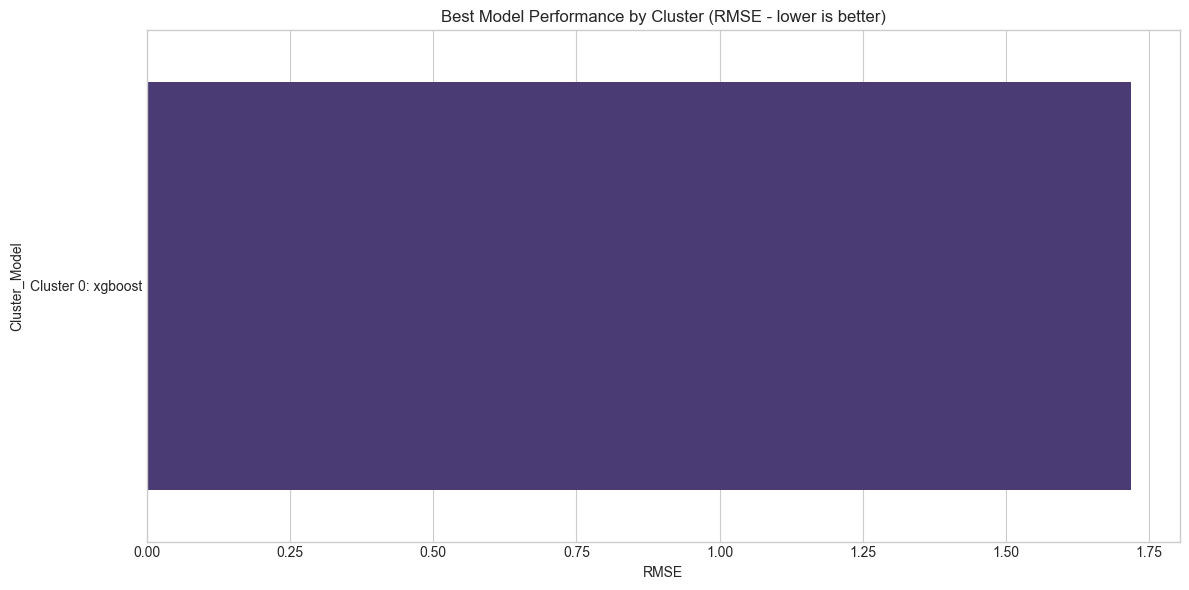

In [ ]:
# Create a summary of best models across clusters
summary_rows = []
for cluster_id in all_cluster_comparisons:
    best_model = all_cluster_comparisons[cluster_id].iloc[0]
    summary_rows.append({
        'Cluster': cluster_id,
        'Best Model': best_model['Model'],
        'RMSE': best_model['RMSE'],
    })

cluster_summary = pd.DataFrame(summary_rows).sort_values('RMSE')

print("\nBest Models by Cluster:")
print(cluster_summary)

# Plot cluster performance comparison
plt.figure(figsize=(12, 6))
cluster_summary_plot = cluster_summary.copy()
cluster_summary_plot['Cluster_Model'] = cluster_summary_plot.apply(
    lambda x: f"Cluster {x['Cluster']}: {x['Best Model']}", axis=1
)
sns.barplot(x='RMSE', y='Cluster_Model', data=cluster_summary_plot)
plt.title('Best Model Performance by Cluster (RMSE - lower is better)')
plt.tight_layout()
plt.show()

In [ ]:
all_cluster_results

## Citywide

--> Bei gutem Wetter fahren mehr Menschen Fahrrad

Out:
- Feature importance
- Coeff

Train models on all data, ignoring cluster

In [ ]:
models_to_train = ['linear', 'lasso', 'ridge', 'polynomial', 'decision_tree', 'xgboost']

## Random Forest

TODO

- Split data to range from May 10 - 20
- Adjust checkpointing to include column about this split (bool)
- Train **all** models on this data, including random forest

In [ ]:
models_to_train = ['linear', 'lasso', 'ridge', 'polynomial', 'decision_tree', 'xgboost', 'random_forest']